<a href="https://colab.research.google.com/github/RosaliaGimenezBDS/M9_Reto_2/blob/main/Reto_2_M09_Notebook_2%20y%20Notebook_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Máster en Behavioral Data Science**
## **Instituto de Formación Continua (IL3) - Universitat de Barcelona**
## **Módulo 9: Aprendizaje Profundo - Reto 2** - (Notebook 2/4)
Autor: **Meysam Madadi**

Colaborador: **Julio C. S. Jacques Junior**

---

# **Los objetivos de este Jupyter notebook**
- Crear nuestro primer modelo utilizando información de texto como entrada.
- Comparar dos estrategias de fusión de características:
 - utilizando un modelo secuencial (LSTM)
 - utilizando el valor promedio
- Predecir la personalidad aparente a partir de datos textuales.
- Visualizar los resultados.

## **Descargando y descomprimiendo los datos**
- Aunque se descargue el conjunto de datos preprocesado completo, en este *notebook* solo trabajaremos con datos textuales (es decir, características de transcripción de video extraídas por BERT).

In [1]:
# Download and unzip the data
!wget https://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r2/data_final.zip
!unzip ./data_final.zip

Se han truncado las últimas 5000 líneas del flujo de salida.
  inflating: data_final/validation/qj-3b8snKho.002/001.jpg  
  inflating: data_final/validation/qj-3b8snKho.002/096.jpg  
  inflating: data_final/validation/qj-3b8snKho.002/191.jpg  
  inflating: data_final/validation/qj-3b8snKho.002/286.jpg  
  inflating: data_final/validation/qj-3b8snKho.002/annotation.npy  
  inflating: data_final/validation/qj-3b8snKho.002/transcription_features.npy  
   creating: data_final/validation/qJ6_xSx9kCM.002/
  inflating: data_final/validation/qJ6_xSx9kCM.002/001.jpg  
  inflating: data_final/validation/qJ6_xSx9kCM.002/115.jpg  
  inflating: data_final/validation/qJ6_xSx9kCM.002/229.jpg  
  inflating: data_final/validation/qJ6_xSx9kCM.002/343.jpg  
  inflating: data_final/validation/qJ6_xSx9kCM.002/annotation.npy  
  inflating: data_final/validation/qJ6_xSx9kCM.002/transcription_features.npy  
   creating: data_final/validation/QJcc95Y0XPw.002/
  inflating: data_final/validation/QJcc95Y0XPw.002/

## Importando las librerías necesarias para ejecutar el código
- Los modelos están implementados y entrenados usando la librería Keras.

In [18]:
import tensorflow as tf
import tf_keras
from tensorflow.keras import optimizers
#from keras.models import Sequential
from tf_keras.models import Sequential
#from keras.layers import Dense, Activation, Dropout, BatchNormalization, ReLU, LeakyReLU, LSTM
from tf_keras.layers import Dense, Activation, Dropout, BatchNormalization, ReLU, LeakyReLU, LSTM
from keras import regularizers
import numpy as np

## **Definiendo nuestra clase "DataGenerator" para cargar los datos en lotes**

- Esta es una forma estándar en Keras de cargar los datos por lotes en casos donde el conjunto de datos es demasiado grande para caber en la memoria. Por lo tanto, es necesario leer/cargar los datos secuencialmente desde el disco.

- La clase "DataGenerator" debe tener al menos dos funciones: **\_\_len__()** para devolver el número de lotes (*batches*) en cada "*epoch*" y **\_\_getitem(step)__** para devolver los datos del lote para un determinado paso de entranamiento, como "X" e "y", donde "X" es la lista de entradas e "y" son las etiquetas.

En nuestra implementación, "DataGenerator" se inicializa con diferentes variables de entrada:
- **data_list** es una lista de nombres de archivos de video para conjuntos de entrenamiento, validación o prueba,
- **root** es la ruta al conjunto de destino (es decir, entrenamiento, validación o prueba),
- **is_sequence** indica si las funciones de transcripción se dan como una secuencia de *tokens* o como promedio,
- **batch_size** es el tamaño del lote,
- **shuffle** se refiere a la aleatorización del orden de los ejemplos de entrenamiento antes de enviarlos a la función de entrenamiento durante cada *epoch*. Es habitual desordenar el orden de las muestras de entrenamento para que el algoritmo de aprendizaje reciba un orden diferente de muestras en cada *epoch*.

En este *Jupyter Notebook*, tratamos las características de transcripción de dos maneras:
- **Estrategia 1:** como una secuencia de "*tokens*". En este caso, los datos tienen una forma de **(batch_size, F, 768)** donde F es el número de "*tokens*" y 768 es la dimensionalidad de las características dadas por BERT. Sin embargo, dado que cada transcripción tiene un número diferente de "*tokens*", fijamos F para que sea el número máximo posible de "*tokens*" (=114). Para transcripciones con un número menor de "*tokens*" que 114, llenamos los que faltan con cero para asegurarnos de tener siempre un tensor de entrada de forma fija.
- **Estrategia 2:** los *tokens* se fusionan mediante una operación de promedio simple. En este caso, los datos tienen una forma de (batch_size, 768).

**Nota importante:** debemos tener en cuenta que podemos cargar nuestro conjunto de datos en un modelo de aprendizaje profundo sin la necesidad de implementar una función "DataGenerator" compleja. Esto dependerá de los recursos computacionales que tengamos (GPU) y del tamaño de nuestro conjunto de datos. El método del generador de datos utilizado en este reto se propuso como una alternativa para lidiar con las limitaciones de Colab. Podéis consultar la documentación de Keras para aprender diferentes (y más simples) formas de cargar los datos durante el entrenamiento, que podrían utilizarse en otros contextos.

In [19]:
class DataGenerator(tf_keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_list, root, is_sequence=False, batch_size=16, shuffle=True):
        super().__init__()
        'Initialization'
        self.data_list = data_list
        self.root = root
        self.is_sequence = is_sequence
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        data_list_temp = [self.data_list[k] for k in indexes]

        # Generate data
        X, Y = self.__data_generation(data_list_temp)

        return X, Y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, data_list):
      'Generates data containing batch_size samples' # X : (batch_size, 114, 768) or (batch_size, 768)
      X, Y = [], []
      n_max = 114 # the possible maximum number of tokens in a cell
      for f in data_list:
        features = np.load(open(self.root+f+'/transcription_features.npy', 'rb'))[0]
        if self.is_sequence:
          n_seq, n_feat = features.shape
          # if the number of tokens is smaller than the maximum number of tokens,...
          # we pad the features with zero to have a fixed length sequence
          if n_seq < n_max:
            features = np.concatenate([np.zeros((n_max - n_seq, n_feat)), features], axis=0)
        else:
          # the features of all words are averaged
          features = np.mean(features, axis=0)
        X.append(features)

        # ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']
        traits = np.load(open(self.root+f+'/annotation.npy', 'rb'))
        Y.append(traits)

      return np.array(X, np.float32), np.array(Y, np.float32)

## **Construyendo nuestro modelo de red neuronal: solo información textual**

- En función de si queremos un modelo secuencial o no podemos diseñar la red. Para esto, podemos configurar la variable **"is_sequential"** como **True** o **False** en la siguiente celda.
- En el caso de características secuenciales (estrategia 1), definimos dos capas recurrentes en forma de LSTM ("*long short term memory*"). En la primera capa LSTM, las características actualizadas por *token* se devuelven con una forma de salida de (batch_size, 114, 768). En la segunda capa LSTM, solo se devuelven las características actualizadas del último "*token*". Finalmente, se agrega un MLP para predecir los cinco rasgos de personalidad.
- Si el modelo no es secuencial (estrategia 2), la red es un MLP (perceptrón multi-capas) simple con un solo vector promedio de *tokens* de entrada.
- Al final de la siguiente celda mostramos una representación visual de nuestro modelo.


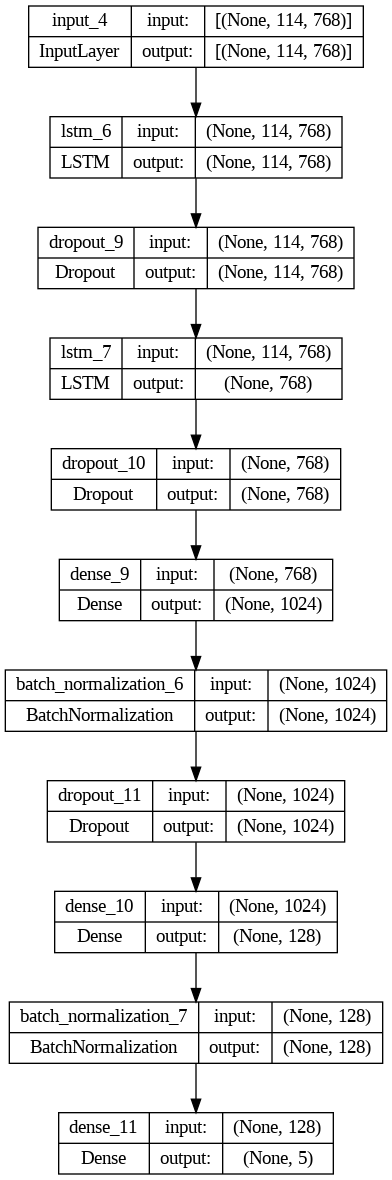

In [20]:
is_sequential = True

# Create model
def create_model(is_sequential):

    model = Sequential()

    if is_sequential:
      model.add(tf_keras.Input(shape=(114, 768)))

      model.add(LSTM(768,input_shape=(114, 768), activation=None, return_sequences=True))
      model.add(Dropout(0.2))

      model.add(LSTM(768, activation=None))
      model.add(Dropout(0.2))
    else:
      model.add(tf_keras.Input(shape=(768,)))

    # MLP
    model.add(Dense(1024, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.2))

    model.add(Dense(128, activation='relu'))
    model.add(BatchNormalization())

    model.add(Dense(5, activation='sigmoid'))

    return model

model = create_model(is_sequential)
#print(model.summary())
tf_keras.utils.plot_model(model, show_shapes=True)

## **Leyendo la lista de archivos de entrenamiento, validación y prueba**

In [21]:
# Read the data lists

with open('train.txt', 'r') as f:
  train_list = f.readlines()
  for i in range(len(train_list)):
    train_list[i] = train_list[i].rsplit('\n',1)[0]

with open('validation.txt', 'r') as f:
  validation_list = f.readlines()
  for i in range(len(validation_list)):
    validation_list[i] = validation_list[i].rsplit('\n',1)[0]

with open('test.txt', 'r') as f:
  test_list = f.readlines()
  for i in range(len(test_list)):
    test_list[i] = test_list[i].rsplit('\n',1)[0]

## **Entrenando y evaluando nuestro modelo**

El modelo se entrena con el optimizador Adam, con una tasa de aprendizaje de 1e-5 y una función de pérdida de error cuadrático medio (L2). El tamaño del lote es 32, y el modelo se entrena durante 20 *epochs*. Se define un "callback" para guardar el mejor modelo entrenado en función del error absoluto medio observado en el conjunto de validación. Finalmente, se guarda el registro del historial en la ruta definida y se evalúa el modelo en el conjunto de pruebas.


In [22]:
# Training
import gc
import random
import pickle

lr = 1e-5
batch_size = 32
n_epochs = 20
checkpoint = './best_model_text_sequential.h5' if is_sequential else './best_model_text_avg.h5'
shuffle = True
verbose = 1

# creating data generators to load the data
train_dg = DataGenerator(train_list, './data_final/train/', is_sequence=is_sequential, batch_size=batch_size, shuffle=shuffle)
validation_dg = DataGenerator(validation_list, './data_final/validation/', is_sequence=is_sequential, batch_size=batch_size, shuffle=False)
test_dg = DataGenerator(test_list, './data_final/test/', is_sequence=is_sequential, batch_size=batch_size, shuffle=False)

# defining the optimizer
model.compile(tf_keras.optimizers.Adam(learning_rate=lr), loss=tf_keras.losses.MeanSquaredError(), metrics=['mae'])

# saving the best model based on val_loss
mc = tf_keras.callbacks.ModelCheckpoint(checkpoint, monitor='val_mae', mode='min', save_best_only=True)

# training the model and saving the history
history = model.fit(train_dg, validation_data=validation_dg, epochs=n_epochs, verbose=verbose, callbacks=[mc])
with open('./train_history_text_sequential.pkl' if is_sequential else './train_history_text_avg.pkl', 'wb') as handle:
  pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)


Epoch 1/20
124/124 [==============================] - ETA: 0s - loss: 0.0862 - mae: 0.2426

/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


124/124 [==============================] - 51s 352ms/step - loss: 0.0862 - mae: 0.2426 - val_loss: 0.0288 - val_mae: 0.1364
Epoch 2/20
124/124 [==============================] - 46s 373ms/step - loss: 0.0777 - mae: 0.2289 - val_loss: 0.0338 - val_mae: 0.1473
Epoch 3/20
124/124 [==============================] - 42s 342ms/step - loss: 0.0737 - mae: 0.2221 - val_loss: 0.0349 - val_mae: 0.1489
Epoch 4/20
124/124 [==============================] - 44s 354ms/step - loss: 0.0699 - mae: 0.2155 - val_loss: 0.0374 - val_mae: 0.1542
Epoch 5/20
124/124 [==============================] - 43s 344ms/step - loss: 0.0658 - mae: 0.2085 - val_loss: 0.0412 - val_mae: 0.1618
Epoch 6/20
124/124 [==============================] - 43s 345ms/step - loss: 0.0626 - mae: 0.2034 - val_loss: 0.0432 - val_mae: 0.1655
Epoch 7/20
124/124 [==============================] - 43s 343ms/step - loss: 0.0589 - mae: 0.1965 - val_loss: 0.0434 - val_mae: 0.1667
Epoch 8/20
124/124 [==============================] - 43s 343ms/st

In [23]:
# Creating/building our model again, and loading the last checkpoint (best model)
model = create_model(is_sequential)
model.load_weights(checkpoint)
model.compile(tf_keras.optimizers.Adam(learning_rate=lr), loss=tf_keras.losses.MeanSquaredError(), metrics=['mae'])

# Evaluate the trained model on the test set

# Some house keeping
gc.collect()
tf_keras.backend.clear_session()

print('Evaluating on the test set')

_loss = 0
_mae = 0
for step in range(test_dg.__len__()):
  # Load the batch
  X, Y = test_dg.__getitem__(step)

  # validate on one batch
  loss, mae = model.evaluate(
      tf.convert_to_tensor(X, dtype=tf.float32),
      tf.convert_to_tensor(Y, dtype=tf.float32),
      verbose = 0)

  _loss += loss
  _mae += mae
step += 1
print("The final mean absolute error is {0:.5f}\n".format(_mae/step))

Evaluating on the test set
The final mean absolute error is 0.13569



## **Visualizando las curvas de entrenamiento**
- Pérdida de entrenamiento y validación, y MAE para cada *epoch*.
- Las curvas de entrenamiento pueden ayudarnos a entender un poco el comportamiento del modelo. Por ejemplo, si el modelo se está sobreajustando, o si el modelo aún estaba aprendiendo al final del entrenamiento, etc.

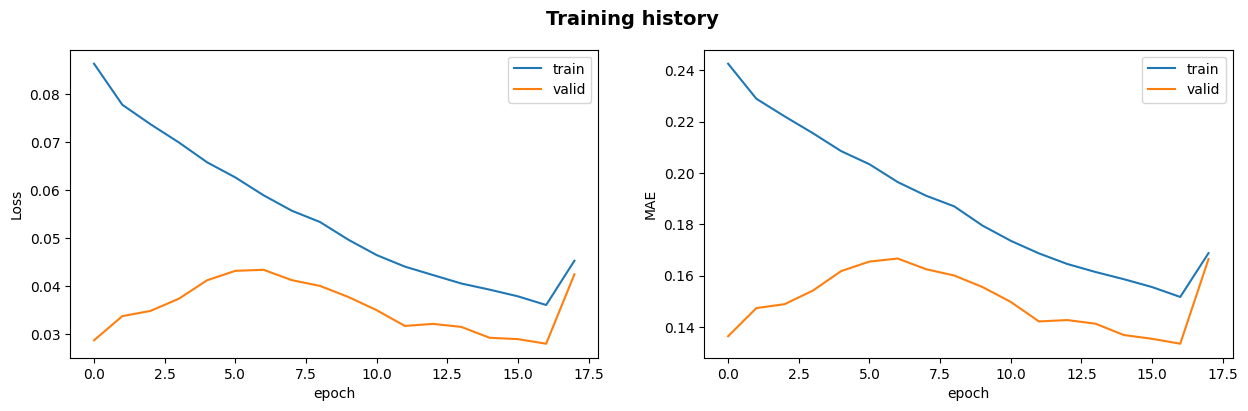

In [24]:
# Visualization
from matplotlib import pyplot as plt

# Load the history
train_hist = pickle.load(open('./train_history_text_sequential.pkl' if is_sequential else './train_history_text_avg.pkl',"rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')

# **Máster en Behavioral Data Science**
## **Instituto de Formación Continua (IL3) - Universitat de Barcelona**
## **Módulo 9: Aprendizaje Profundo - Reto 2** - (Notebook 3/4)
Autor: **Meysam Madadi**

Colaborador: **Julio C. S. Jacques Junior**

---

# **Los objetivos de este Jupyter notebook**
- Crear nuestro modelo para datos de imagen.
- Comparar el entrenamiento con una sola imagen vs. una secuencia de imágenes.
- Predecir la personalidad aparente de los individuos a partir de datos de imágenes.
- Visualizar los resultados.

## **Descargando y descomprimiendo los datos**

- En este *Jupyter Notebook* solo trabajamos con datos de imágenes (obtenidas de los videos). Las muestras de imágenes se han redimensionado a **(224, 224, 3)**. Hemos definido un máximo de 4 imágenes para representar cada secuencia de video. Podemos definir cuántas imágenes se utilizarán para entrenamiento/prueba. Para esto, podemos cambiar el valor de la variable **"n\_frames"** (a continuación) por un valor entero en el rango [1,...,4].

- Para este reto, hemos reimplementado la función **model.fit()** de *Keras* en una nueva clase, llamada **MyModel**, disponible en el archivo **myfunctions.py**. Esto se debe a algunos problemas técnicos que hemos tenido, muy probablemente causados por las limitaciones de memoria de Colab. Dicho esto, no deberíais tener problemas al utilizar las clases originales de *Keras* al ejecutar vuestros modelos en un entorno más potente.


In [28]:
# Download and unzip the data
!wget https://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r2/data_final.zip
!unzip ./data_final.zip

# Download the file in which we have reimplemented Model class
#!wget https://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r2/myfunctions.py
!wget https://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r2/myfunctionsV2.py

--2024-09-18 17:52:55--  https://data.chalearnlap.cvc.uab.cat/Colab_MFPDS/2024BehaviorDSMaster/M9_r2/myfunctionsV2.py
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3624 (3.5K) [application/octet-stream]
Saving to: ‘myfunctionsV2.py’

myfunctionsV2.py    100%[===================>]   3.54K  --.-KB/s    in 0s      

2024-09-18 17:52:55 (1.16 GB/s) - ‘myfunctionsV2.py’ saved [3624/3624]



## Importando las librerías necesarias para ejecutar el código
- Los modelos están implementados y entrenados usando la librería Keras.

In [29]:
import tensorflow as tf
import tf_keras
from tensorflow.keras import optimizers
#from keras.models import Sequential
from tf_keras.models import Sequential
#from keras.layers import Dense, Activation, Dropout, BatchNormalization, ReLU, LeakyReLU, LSTM, Reshape, GlobalMaxPooling1D, GlobalAveragePooling1D
from tf_keras.layers import Dense, Activation, Dropout, BatchNormalization, ReLU, LeakyReLU, LSTM, Reshape, GlobalMaxPooling1D, GlobalAveragePooling1D
import keras.backend as K
import numpy as np
import tensorflow.keras.applications as app
from tensorflow.keras.models import Model
from myfunctionsV2 import MyModel, reshape
from glob import glob
import cv2

# Number of frames used
##################
n_frames = 1
##################

if n_frames>4:
  print("n_frames must be between 1 and 4. It is set to 4.")
  n_frames = 4
elif n_frames<1:
  print("n_frames must be between 1 and 4. It is set to 1.")
  n_frames = 1

## **Definiendo nuestra clase "DataGenerator" para cargar los datos en lotes**

Nuestra clase "DataGenerator" se inicializa con diferentes variables de entrada:
- **data_list** es una lista de nombres de archivos de video contenidos en los conjuntos de entrenamiento, validación o prueba,
- **root** es la ruta al conjunto de destino (es decir, entrenamiento, validación o prueba),
- **n_frames** indica el número de imágenes por vídeo,
- **batch_size** es el tamaño del lote,
- **shuffle** se refiere a la aleatorización del orden de los ejemplos de entrenamiento antes de enviarlos a la función de entrenamiento durante cada *epoch*. Es habitual desordenar el orden de las muestras de entrenamento para que el algoritmo de aprendizaje reciba un orden diferente de muestras en cada *epoch*.

Los datos devueltos tienen la forma de **(batch_size, n_frames, 224, 224, 3)**.


In [30]:
class DataGenerator(tf_keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, data_list, root, n_frames=4, batch_size=16, shuffle=True):
        super().__init__()
        'Initialization'
        self.data_list = data_list
        self.root = root
        self.n_frames = n_frames
        self.batch_size = batch_size
        self.shuffle = shuffle
        # set imagenet pixel mean RGB value for image normalization
        self.mean = np.array([[[103.939, 116.779, 123.68]]], dtype=np.float32)
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.data_list) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        # Find list of IDs
        data_list_temp = [self.data_list[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(data_list_temp)

        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.data_list))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, data_list):
      'Generates data containing batch_size samples' # X : (batch_size, n_frames, 224, 224, 3,)
      X, Y = [], []
      for f in data_list:
        # read the list of images
        files = sorted(glob(self.root+f+'/*.jpg'))
        ximg = []
        for i in range(self.n_frames):
          img = cv2.imread(files[i])
          # process and normalize the image
          img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32) - self.mean
          ximg.append(img)
        X.append(ximg)

        # read annotations
        # ['extraversion', 'neuroticism', 'agreeableness', 'conscientiousness', 'openness']
        traits = np.load(open(self.root+f+'/annotation.npy', 'rb'))
        Y.append(traits)

      return np.array(X, np.float32), np.array(Y, np.float32)

## **Construyendo nuestro modelo de red neuronal: solo información visual**

- Hay muchas maneras diferentes de manejar datos de imágenes secuenciales (videos). En un video, el orden de los cuadros es importante para capturar información de contexto. Sin embargo, en este conjunto de datos, tomamos muestras de algunos cuadros (de 1 a un máximo de 4) de cada video sin tener en cuenta el orden. Es decir, se ignora el orden de los cuadros. Para abordar este problema, hemos diseñado un modelo que puede aprender a partir de imágenes sin necesidad de que estén ordenadas.

- En este reto, utilizaremos un modelo ResNet50 que recibe una única imagen como entrada. Originalmente, ResNet50 tiene una "cabeza de clasificación". Es decir, las últimas capas están diseñadas para solucionar un problema de clasificación. En nuestro caso, el modelo ha sido rediseñado (las últimas capas) para solucionar un problema de regresión (para predecir los 5 valores de los rasgos de personalidad).

- La entrada de nuestra red es una imagen de tamaño **(224, 224, 3)**, proporcionada por el "*DataGenerator*". El vector de características de salida del modelo tiene una forma de **(7, 7, 2048)**, excluyendo el tamaño del lote: **(batch_size, 7, 7, 2048)**

- Nuestra implementación permite que tengamos múltiples cuadros (imágenes) como entrada (hasta 4). Sin embargo, nuestro modelo procesará cada imagen de forma independiente.

- Los datos de entrada tienen la forma de **(batch_size, n_frames, 224, 224, 3)**. Para este reto, hemos implementado una capa especial de "*reshaping*" (disponible en myfunctions.py) que remodela los datos de entrada a **(batch_size $\times$ n_frames, 224, 224, 3)**. Luego, la forma de las características de salida será **(batch_size $\times$ n_frames, 7, 7, 2048)**. A continuación, aplicamos un "*reshaping*" para agrupar las características de los cuadros de cada vídeo como **(batch_size, n_frames $\times$ 7 $\times$ 7, 2048)**.

- Las operaciones de "*MaxPooling*" y "*AveragePooling*" se pueden utilizar para la fusión cuando se ignora el orden de las imágenes. Luego, la salida de esta capa de fusión será **(batch_size, 2048)**. Finalmente, agregamos un MLP como una "cabeza de regresión" para predecir los rasgos de personalidad.

- Debemos tener en cuenta que ResNet50 se inicializa mediante pesos preentrenados en el conjunto de datos de **ImageNet**, beneficiándose así del **aprendizaje por transferencia**.


In [31]:
def create_model():
    # Create model
    net_name = ['resnet50','ResNet50']

    # Select the corresponding network class
    mynet = getattr(getattr(app, net_name[0]), net_name[1])

    base_model = mynet(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

    input = tf_keras.Input(shape=(n_frames, 224, 224, 3))

    x = reshape(n_frames)(input)#(batch_size*n_frames, 224, 224, 3)

    x = base_model(x)#(batch_size*n_frames, 7, 7, 2048)

    # add a global spatial max pooling layer among all frames of a video after reshaping the features
    x = reshape(n_frames)(x)#(batch_size, n_frames*7*7, 2048)

    #===============================================
    #x = GlobalMaxPooling1D()(x)#(batch_size, 2048)
    x = GlobalAveragePooling1D()(x)#(batch_size, 2048)
    #===============================================

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)

    x = Dropout(0.2)(x)

    x = Dense(1024, activation='relu')(x)
    x = BatchNormalization()(x)

    #===============================================
    predictions = Dense(5, activation='sigmoid')(x)
    #predictions = Dense(5, activation=None)(x)
    #===============================================

    # this is the model we will train
    model = MyModel(inputs=input, outputs=predictions)

    return model

model = create_model()
print(model.summary())
#tf_keras.utils.plot_model(model, show_shapes=True)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "my_model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 1, 224, 224, 3)]     0         []                            
                                                                                                  
 reshape (reshape)           (None, 224, 224, 3)          0         ['input_1[0][0]']             
                                                                                                  
 tf.compat.v1.pad (TFOpLamb  (None, 230, 230, 3)          0         ['reshape[0][0]']             
 da)                                                                                              
                                                                                                  
 tf.nn.convolution (TFOpLam  (None, 112, 112, 64)         0         ['tf.compat.v1.pad[0][0

## **Leyendo la lista de archivos de entrenamiento, validación y prueba**

In [32]:
# Read the data lists
with open('train.txt', 'r') as f:
  train_list = f.readlines()
  for i in range(len(train_list)):
    train_list[i] = train_list[i].rsplit('\n',1)[0]

with open('validation.txt', 'r') as f:
  validation_list = f.readlines()
  for i in range(len(validation_list)):
    validation_list[i] = validation_list[i].rsplit('\n',1)[0]

with open('test.txt', 'r') as f:
  test_list = f.readlines()
  for i in range(len(test_list)):
    test_list[i] = test_list[i].rsplit('\n',1)[0]

## **Entrenando y evaluando nuestro modelo**

El modelo se entrena con el optimizador Adam con una tasa de aprendizaje de 1e-5 y una función de pérdida de error cuadrático medio (L2). El tamaño del lote es 32 y el modelo se entrena durante 20 *epochs*. Se define un "callback" para guardar el mejor modelo entrenado en función del error absoluto medio observado en el conjunto de validación. Finalmente, se guarda el registro del historial en la ruta definida y se evalúa el modelo en el conjunto de pruebas.



In [33]:
#CODIGO ORIGINAL - CORREGIDO PORQUE ME ECHA POR AGOTAR LA RAM
# Training
import gc
import random
import pickle

lr = 1e-5
batch_size = 32
n_epochs = 20
checkpoint = './best_model_image'+str(n_frames)+'.h5'
shuffle = True
verbose = 1

# creating data generators to load the data
train_dg = DataGenerator(train_list, './data_final/train/', n_frames=n_frames, batch_size=batch_size, shuffle=shuffle)
validation_dg = DataGenerator(validation_list, './data_final/validation/', n_frames=n_frames, batch_size=batch_size, shuffle=False)
test_dg = DataGenerator(test_list, './data_final/test/', n_frames=n_frames, batch_size=batch_size, shuffle=False)

# defining the optimizer
model.compile(tf_keras.optimizers.Adam(learning_rate=lr), loss=tf_keras.losses.MeanSquaredError(), metrics=['mae'])

history = model.fit(train_dg, validation_dg, epochs=n_epochs, verbose=verbose, checkpoint=checkpoint)

with open('./train_history_image'+str(n_frames)+'.pkl', 'wb') as handle:
  pickle.dump(history, handle, protocol=pickle.HIGHEST_PROTOCOL)


epoch 0 training loss: 0.08, mae: 0.23
epoch 0 valid    loss: 0.04, mae: 0.16



/usr/local/lib/python3.10/dist-packages/tf_keras/src/engine/training.py:3098: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native TF-Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


epoch 1 training loss: 0.07, mae: 0.21
epoch 1 valid    loss: 0.05, mae: 0.18

epoch 2 training loss: 0.06, mae: 0.20
epoch 2 valid    loss: 0.05, mae: 0.19

epoch 3 training loss: 0.05, mae: 0.18
epoch 3 valid    loss: 0.06, mae: 0.19

epoch 4 training loss: 0.05, mae: 0.18
epoch 4 valid    loss: 0.06, mae: 0.19

epoch 5 training loss: 0.04, mae: 0.17
epoch 5 valid    loss: 0.06, mae: 0.19

epoch 6 training loss: 0.04, mae: 0.16
epoch 6 valid    loss: 0.05, mae: 0.19

epoch 7 training loss: 0.04, mae: 0.16
epoch 7 valid    loss: 0.05, mae: 0.19

epoch 8 training loss: 0.04, mae: 0.15
epoch 8 valid    loss: 0.05, mae: 0.18

epoch 9 training loss: 0.03, mae: 0.15
epoch 9 valid    loss: 0.05, mae: 0.18

epoch 10 training loss: 0.03, mae: 0.14
epoch 10 valid    loss: 0.05, mae: 0.18

epoch 11 training loss: 0.03, mae: 0.14
epoch 11 valid    loss: 0.05, mae: 0.18

epoch 12 training loss: 0.03, mae: 0.14
epoch 12 valid    loss: 0.05, mae: 0.18

epoch 13 training loss: 0.03, mae: 0.13
epoch 

In [35]:
# Ceating/building our model again, and loading the last checkpoint (best model)
model = create_model()
model.load_weights(checkpoint)
model.compile(tf_keras.optimizers.Adam(learning_rate=lr), loss=tf_keras.losses.MeanSquaredError(), metrics=['mae'])

# Evaluate the trained model on the test set

# Some house keeping
gc.collect()
tf_keras.backend.clear_session()

print('Evaluating on the test set')

_loss = 0
_mae = 0
for step in range(test_dg.__len__()):
  # Load the batch
  X, Y = test_dg.__getitem__(step)

  # validate on one batch
  loss, mae = model.evaluate(
      tf.convert_to_tensor(X, dtype=tf.float32),
      tf.convert_to_tensor(Y, dtype=tf.float32),
      verbose = 0)

  _loss += loss
  _mae += mae
step += 1
print("The final mean absolute error is {0:.5f}\n".format(_mae/step))

Evaluating on the test set
The final mean absolute error is 0.16112



## **Visualizando las curvas de entrenamiento**
- Pérdida de entrenamiento y validación, y MAE para cada *epoch*.
- Las curvas de entrenamiento pueden ayudarnos a entender un poco el comportamiento del modelo. Por ejemplo, si el modelo se está sobreajustando, o si el modelo aún estaba aprendiendo al final del entrenamiento, etc.

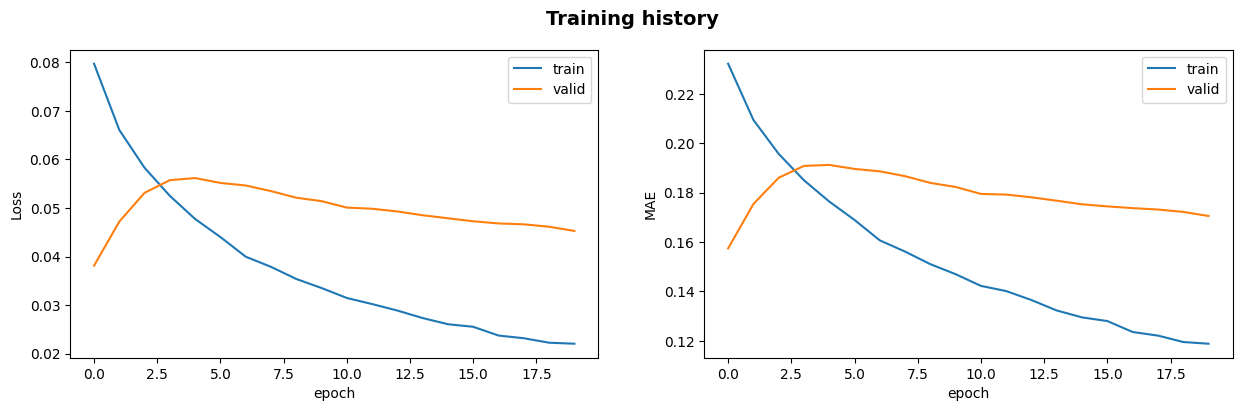

In [36]:
# Visualization
from matplotlib import pyplot as plt

train_hist = pickle.load(open('./train_history_image'+str(n_frames)+'.pkl',"rb"))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Training history', fontsize=14, fontweight='bold')

ax1.plot(train_hist['loss'])
ax1.plot(train_hist['val_loss'])
ax1.set(xlabel='epoch', ylabel='Loss')
ax1.legend(['train', 'valid'], loc='upper right')

ax2.plot(train_hist['mae'])
ax2.plot(train_hist['val_mae'])
ax2.set(xlabel='epoch', ylabel='MAE')
ax2.legend(['train', 'valid'], loc='upper right')